# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import threatgraph

In [2]:
# Number of 'top domains'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [6]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,essential-cb,languid-mac,simon-macpro,traverses-mac,MalcomWare-PC,dramatic-mac,DESKTOP-PIMD8C0,daniel-chromebook,turing-macbook,misskitty-mac,...,ludicrous-mac,steamverne-mac,nervings-cb,appropriate-android,turing-chromebook,venkata,rarb-mac,theatergoing-mac,castle3b7c9f,score
alphonso.tv,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
nuget.org,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,8
dbbest.com,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
debenhams.com,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,2
comixology.com,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
thegoodfoodguide.co.uk,0,0,0,0,0,0,0,0,0,12,...,0,0,0,0,0,0,0,0,0,12
digitru.st,2,3,1,0,0,7,4,0,0,8,...,0,2,1,0,0,0,0,0,0,45
bankofamerica.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
mountainroseherbs.com,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,2
stripe.network,1,0,0,0,0,0,0,0,0,48,...,0,0,0,0,0,0,0,0,0,54


## Get list of highest accessed domains by all devices

In [7]:
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'googleapis.com', ...,
       'sonicwall.com', 'qocjidxwmlmjymb.local', 'idg.pl'], dtype=object)

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite domains by device

In [9]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['essential-cb', array(['google.com', 'clubhouse.io', 'gstatic.com', ...,
         'theotherjournal.com', 'medscapestatic.com', 'ng-book.com'],
        dtype=object)],
 ['languid-mac',
  array(['google.com', 'apple.com', 'in-addr.arpa', ..., 'elsevier.es',
         'woocommerce.com', 'ng-book.com'], dtype=object)],
 ['simon-macpro',
  array(['google.com', 'gstatic.com', 'akadns.net', ..., 'yieldify.com',
         'scrippsdigital.com', 'ng-book.com'], dtype=object)],
 ['traverses-mac', array(['google.com', 'apple.com', 'in-addr.arpa', ...,
         'tywlgghvzigv.openvpn', 'getgo.com', 'ng-book.com'], dtype=object)],
 ['MalcomWare-PC',
  array(['ddns.net', 'trustnetworks.com', 'microsoft.com', ...,
         'huffingtonpost.com', 'ultratools.com', 'ng-book.com'],
        dtype=object)],
 ['dramatic-mac', array(['google.com', 'apple.com', 'rbxcdn.com', ...,
         'davincimeetingrooms.com', 'keras.io', 'ng-book.com'], dtype=object)],
 ['DESKTOP-PIMD8C0',
  array(['microsoft.com', 'trust

In [10]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
essential-cb,"[google.com, clubhouse.io, gstatic.com, google..."
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic...."
simon-macpro,"[google.com, gstatic.com, akadns.net, apple.co..."
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n..."
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g..."
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws...."
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,..."
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g..."
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
misskitty-mac,"[google.com, akadns.net, gstatic.com, googleap...",0.48
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo...",0.32
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",0.27
minesweepers-mac,"[google.com, github.com, in-addr.arpa, clubhou...",0.27
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic....",0.24
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",0.23
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.22
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",0.20
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",0.19


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x)).round(2)

In [14]:
df3

,domains,essential-cb,languid-mac,simon-macpro,traverses-mac,MalcomWare-PC,dramatic-mac,DESKTOP-PIMD8C0,daniel-chromebook,turing-macbook,...,calcannea-mac,ludicrous-mac,steamverne-mac,nervings-cb,appropriate-android,turing-chromebook,venkata,rarb-mac,theatergoing-mac,castle3b7c9f
device,,,,,,,,,,,,,,,,,,,,,
essential-cb,"[google.com, clubhouse.io, gstatic.com, google...",1.00,0.66,0.73,0.69,0.71,0.59,0.71,0.71,0.70,...,0.72,0.70,0.62,0.72,0.72,0.73,0.71,0.72,0.71,0.69
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic....",0.66,1.00,0.72,0.65,0.68,0.65,0.71,0.66,0.65,...,0.66,0.65,0.67,0.70,0.68,0.69,0.68,0.66,0.66,0.64
simon-macpro,"[google.com, gstatic.com, akadns.net, apple.co...",0.73,0.72,1.00,0.77,0.79,0.65,0.80,0.78,0.78,...,0.78,0.78,0.67,0.78,0.79,0.82,0.79,0.79,0.78,0.76
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.69,0.65,0.77,1.00,0.93,0.60,0.84,0.97,0.98,...,0.95,0.98,0.59,0.77,0.84,0.92,0.94,0.94,0.85,0.98
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",0.71,0.68,0.79,0.93,1.00,0.63,0.88,0.93,0.93,...,0.93,0.94,0.62,0.79,0.86,0.91,0.94,0.91,0.86,0.94
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.59,0.65,0.65,0.60,0.63,1.00,0.65,0.59,0.60,...,0.60,0.60,0.63,0.63,0.63,0.63,0.62,0.61,0.60,0.59
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,...",0.71,0.71,0.80,0.84,0.88,0.65,1.00,0.84,0.84,...,0.85,0.84,0.66,0.81,0.85,0.85,0.86,0.84,0.86,0.84
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g...",0.71,0.66,0.78,0.97,0.93,0.59,0.84,1.00,0.97,...,0.95,0.98,0.60,0.78,0.85,0.92,0.94,0.94,0.86,0.97
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.70,0.65,0.78,0.98,0.93,0.60,0.84,0.97,1.00,...,0.96,0.98,0.60,0.77,0.85,0.93,0.94,0.94,0.86,0.97


## Plot heatmap

In [15]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

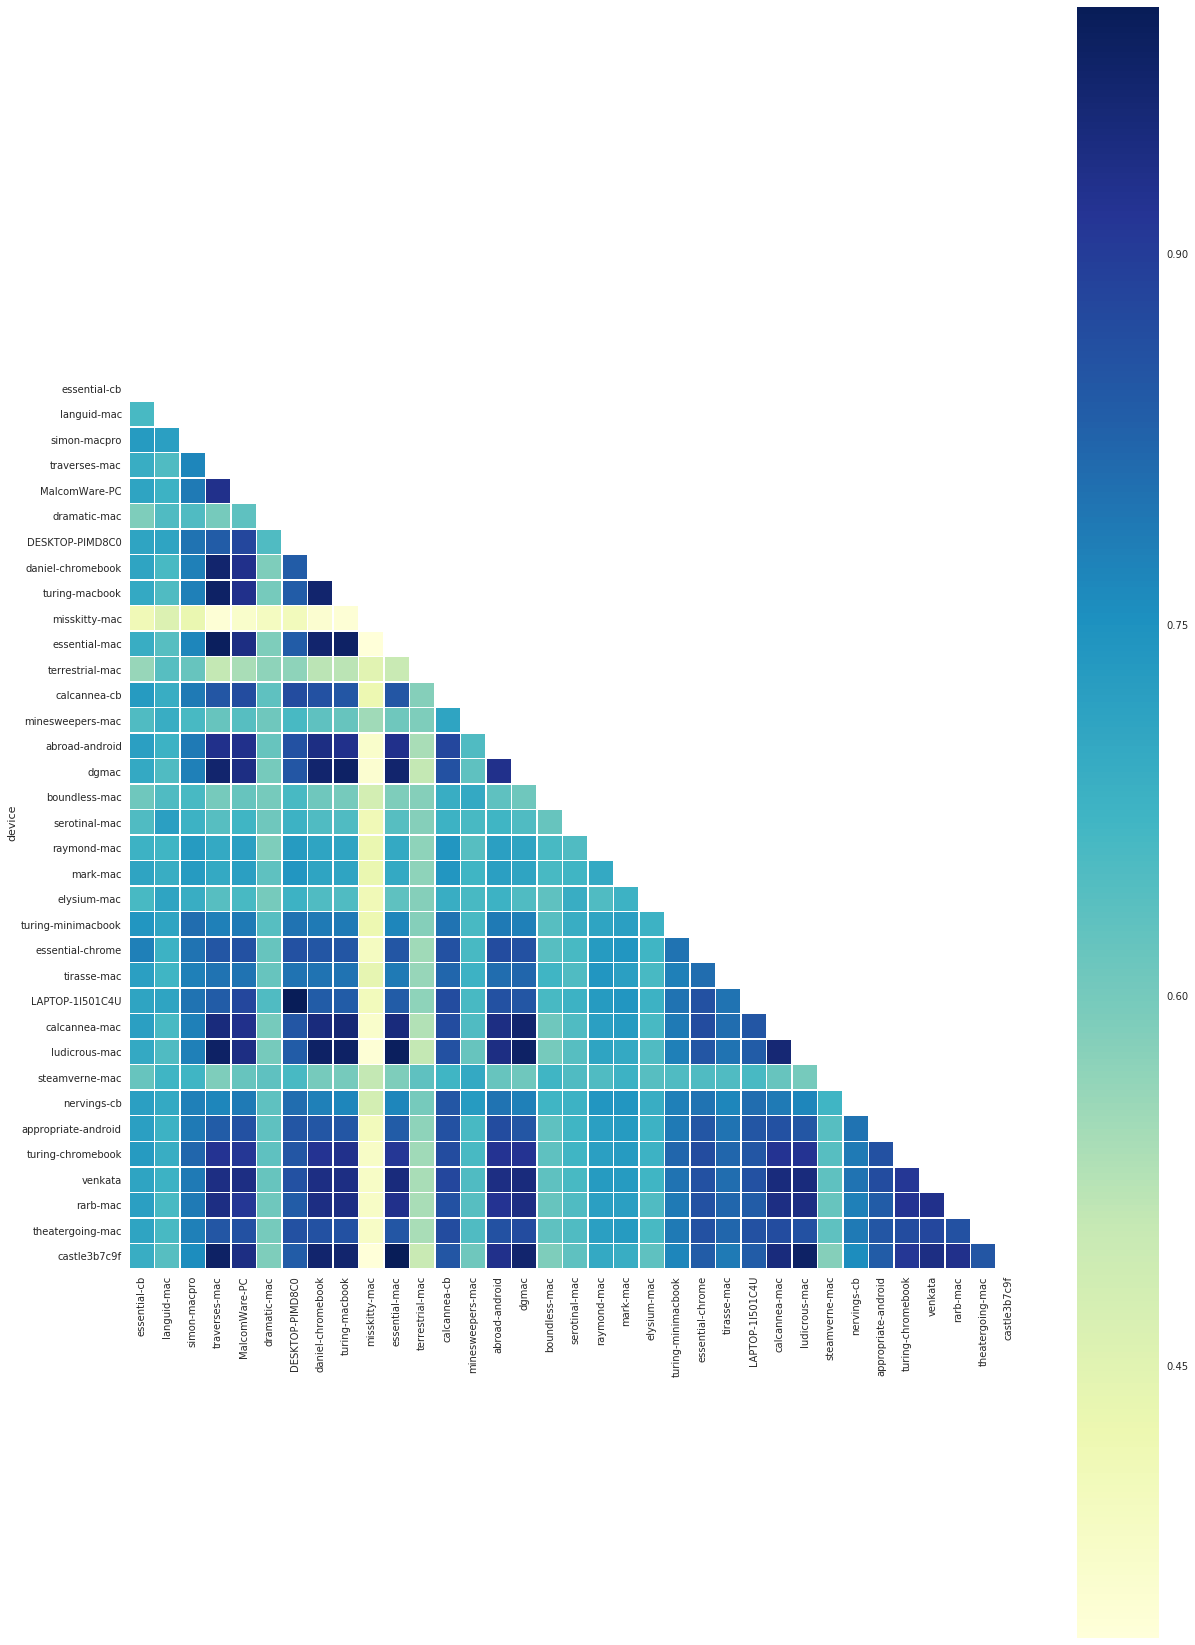

In [16]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Alternative rank correlation

Higher weights nearer the 'top' of the rank list

In [17]:
# Sum of geometric progression
def geosum(a1, r, n):
    return a1 * (1 - r ** n) / (1 - r)

In [18]:
# Calculate Rho on 2 lists
def correlator(a, b):
    
    coeff = 1
    ratio = 0.4
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val * coeff * (ratio ** i)
        
        tot += val
                
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    x = 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )
    s = geosum(coeff, ratio, n)
    x /= s
    return x

In [19]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: correlator(domains, x)).round(6)
df3

,domains,essential-cb,languid-mac,simon-macpro,traverses-mac,MalcomWare-PC,dramatic-mac,DESKTOP-PIMD8C0,daniel-chromebook,turing-macbook,...,calcannea-mac,ludicrous-mac,steamverne-mac,nervings-cb,appropriate-android,turing-chromebook,venkata,rarb-mac,theatergoing-mac,castle3b7c9f
device,,,,,,,,,,,,,,,,,,,,,
essential-cb,"[google.com, clubhouse.io, gstatic.com, google...",0.600000,0.599948,0.599997,0.599947,0.599938,0.599962,0.599934,0.600000,0.599941,...,0.599980,0.599650,0.599999,0.600000,0.599990,0.600000,0.599942,0.599867,0.599998,0.599925
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic....",0.599854,0.600000,0.600000,0.600000,0.599939,0.599966,0.599959,0.600000,0.599994,...,0.599979,0.600000,0.599991,0.599853,0.599990,0.599999,0.599995,0.600000,0.599941,0.599903
simon-macpro,"[google.com, gstatic.com, akadns.net, apple.co...",0.599991,0.600000,0.600000,0.600000,0.599943,0.599971,0.599966,0.600000,0.599994,...,0.599981,0.599973,0.599999,0.599990,0.599991,0.600000,0.599967,0.599996,0.599996,0.599909
traverses-mac,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.599980,0.600000,0.600000,0.600000,0.599888,0.599972,0.599950,0.599992,0.599996,...,0.599905,0.599972,0.599996,0.599988,0.599923,0.599964,0.599974,0.600000,0.599982,0.599949
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",0.599980,0.599926,0.599982,0.599924,0.600000,0.599927,0.599967,0.599978,0.599919,...,0.599903,0.599635,0.599999,0.599987,0.599991,0.599952,0.599919,0.599857,0.599995,0.599944
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.599846,0.600000,0.600000,0.600000,0.599795,0.600000,0.599815,0.599938,0.599996,...,0.599913,0.599986,0.599991,0.599852,0.599989,0.599974,0.599973,0.600000,0.599589,0.599916
DESKTOP-PIMD8C0,"[microsoft.com, trustnetworks.com, mcafee.com,...",0.599981,0.599981,0.599984,0.599976,0.599887,0.599954,0.600000,0.599991,0.599970,...,0.599916,0.599965,0.600000,0.599988,0.599991,0.599970,0.600000,0.599989,0.599995,0.599941
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g...",0.599993,0.599932,0.599985,0.599927,0.599893,0.599948,0.599954,0.600000,0.599921,...,0.599983,0.599645,0.599995,0.599993,0.599991,0.599999,0.599923,0.599862,0.599996,0.599948
turing-macbook,"[google.com, apple.com, in-addr.arpa, akadns.n...",0.599994,0.600000,0.600000,0.600000,0.599893,0.599973,0.599954,0.600000,0.600000,...,0.599984,0.599972,0.599995,0.599993,0.599923,0.600000,0.599974,0.599997,0.599997,0.599948


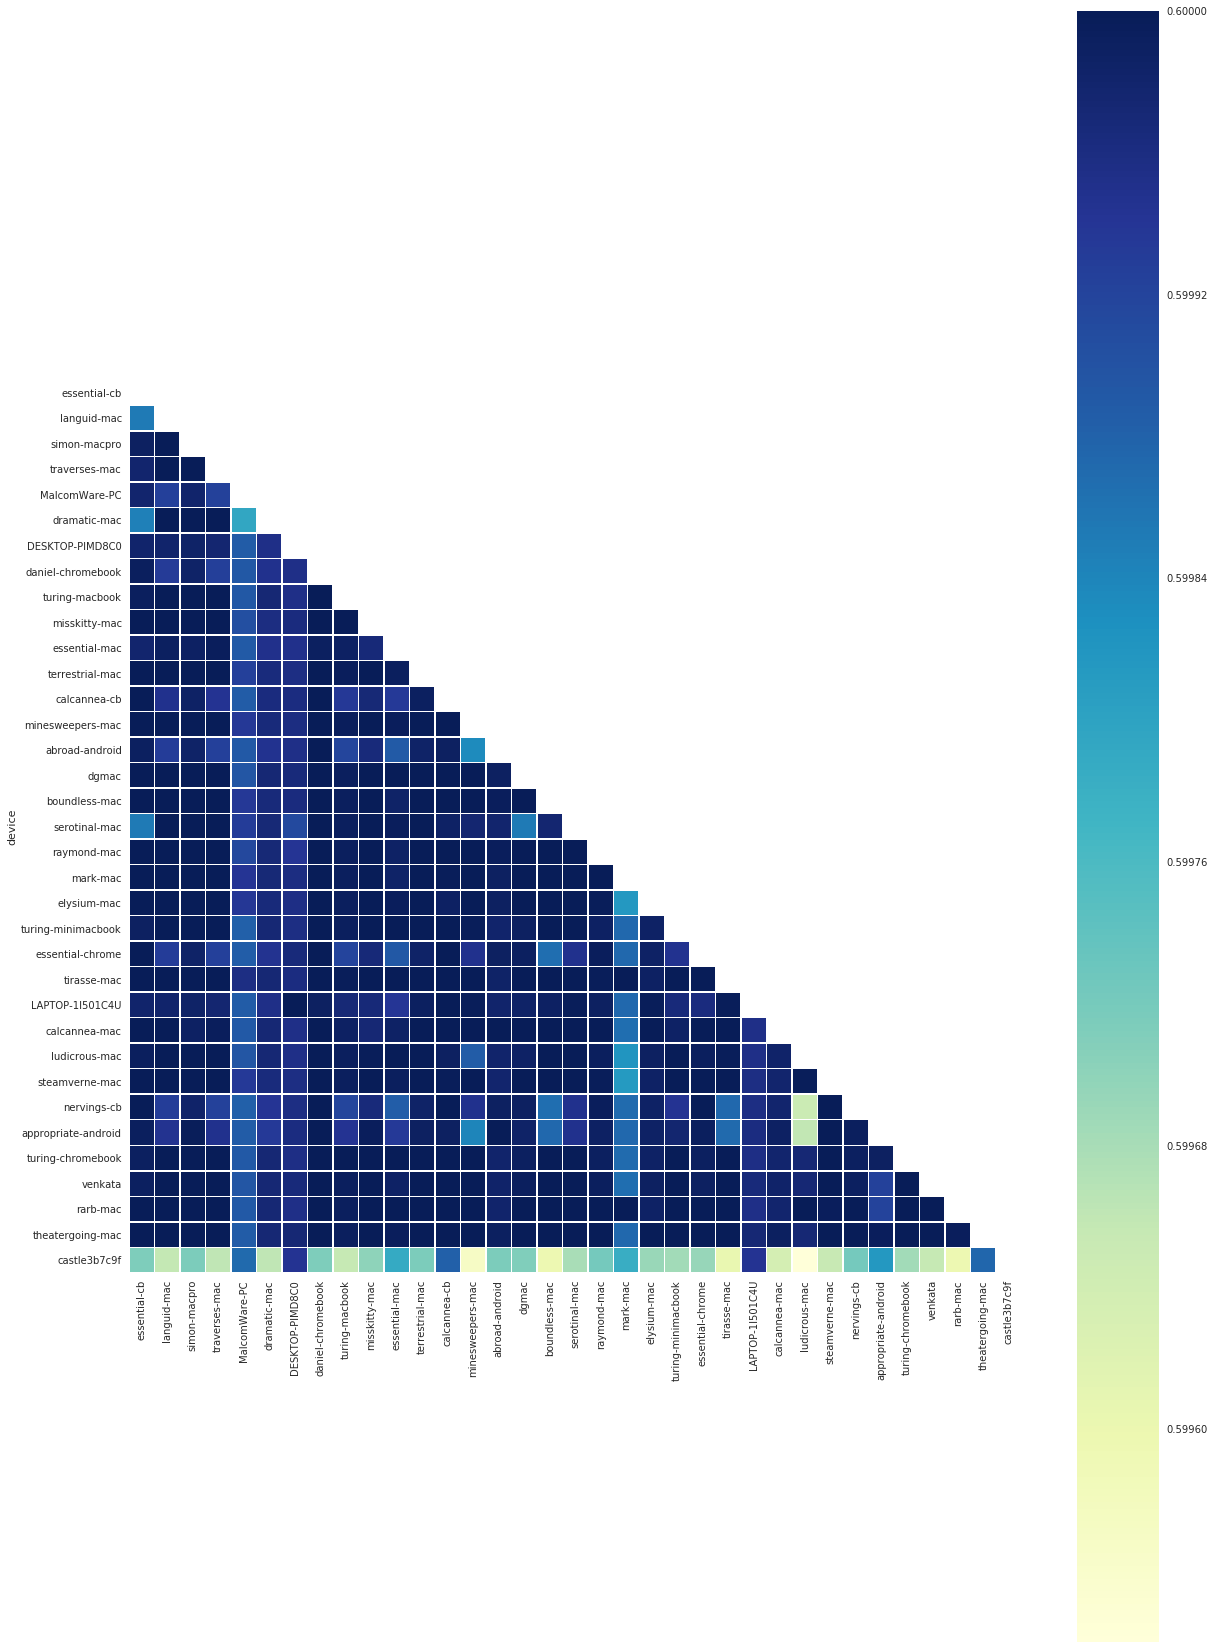

In [20]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()